In [278]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from improc.io import parse_collection, DCAccessor
DCAccessor.register()
import inter_view.color
from skimage.measure import find_contours

from goid.grid import find_template_corners, map_grid, split_path, smooth_path, extrapolate_path_to_boundary, equidistant_point_on_path, closest_point_on_path
from goid.skeleton import find_longest_skeleton_path

In [4]:
basedir='/tungstenfs/scratch/gliberal/Users/zinnmari/GastruloidGeneral/200615MZ001BBB_Sox2BraTC/workflow_out_20210126-141728'

df = pd.read_hdf(os.path.join(basedir, 'output_collection.h5'))
df

pattern  \
platedir          subdir          plate_row plate_column channel zslice                                                      
200615MZ001BBB120 CENTER_SURROUND A         1            1       31      {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                            3            1       32      {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                            4            1       29      {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                            5            1       35      {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                            6            1       41      {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
...                                                                                                                    ...   
200615MZ001BBB96  TIF_OVR_MIP     P         23           2       1       {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                                         3       1       {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                            24           1       1       {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                                         2       1       {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   
                                                         3       1       {basedir}/{platedir}/{subdir}/{date:06d}MZ{f1:...   

                                                                                                                   basedir  \
platedir          subdir          plate_row plate_column channel zslice                                                      
200615MZ001BBB120 CENTER_SURROUND A         1            1       31      /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                            3            1       32      /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                            4            1       29      /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                            5            1       35      /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                            6            1       41      /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
...                                                                                                                    ...   
200615MZ001BBB96  TIF_OVR_MIP     P         23           2       1       /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                                         3       1       /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                            24           1       1       /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                                         2       1       /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   
                                                         3       1       /tungstenfs/scratch/gliberal/Users/zinnmari/Ga...   

                                                                           date  \
platedir          subdir          plate_row plate_column channel zslice           
200615MZ001BBB120 CENTER_SURROUND A         1            1       31      200615   
                                            3            1       32      200615   
                                            4            1       29      200615   
                                            5            1       35      200615   
                                            6            1       41      200615   
...                                                                         ...   
200615MZ001BBB96  TIF_OVR_MIP     P         23           2       1       200615   
                                                         3       1       200615   
       

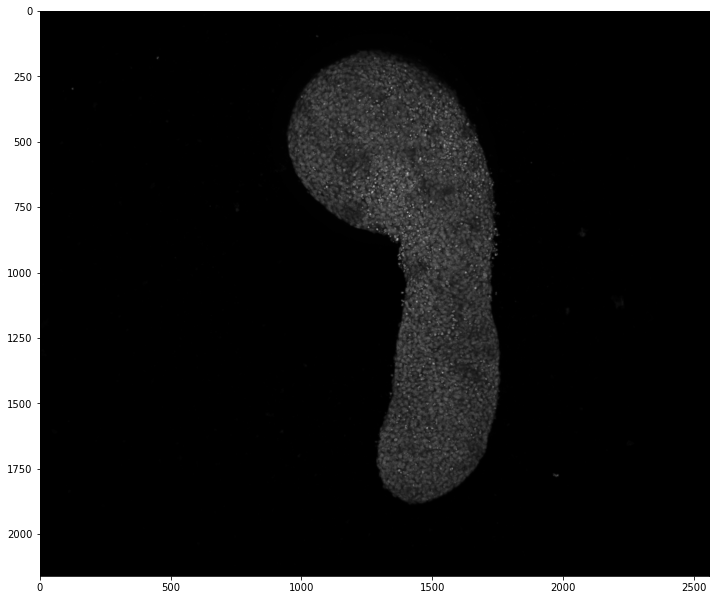

In [294]:
row = 'K'
col = 17

img1 = df.dc['200615MZ001BBB120','TIF_OVR_MIP', row, col,1,1].dc.read()[0]
mask = df.dc['200615MZ001BBB120','FG_MASK', row, col].dc.read()[0].astype(bool)
skel = df.dc['200615MZ001BBB120','SKELETON', row, col].dc.read()[0].astype(bool)
l3 = df.dc['200615MZ001BBB120','SEGMENTS_L3', row, col].dc.read()[0]
l100 = df.dc['200615MZ001BBB120','SEGMENTS_L100', row, col].dc.read()[0]

plt.figure(figsize=(12,12))
plt.imshow(img1[0], cmap='Greys_r')
plt.show()

In [295]:
def find_template_corners(mask, skel_path, debug_plot=False, ax=None):
    '''Find organoid "corners" needed to align a grid'''

    contour = find_contours(mask, 0.5)[0]

    # find points at both ends of the organoid
    endA, endB = extrapolate_path_to_boundary(skel_path, mask,
                                              n_points=2)  # include smoothing
    endA_id = closest_point_on_path(endA, contour)
    endB_id = closest_point_on_path(endB, contour)
    if endA_id > endB_id:
        # clockwise contour, if needed flip skel path
        endA_id, endB_id = sorted([endA_id, endB_id])
        skel_path = skel_path[::-1]
    endA = contour[endA_id]
    endB = contour[endB_id]

    # split in quarters
    l1 = (endB_id - endA_id)
    mid1_id = endA_id + l1 // 2
    l2 = endA_id + (len(contour) - endB_id)
    mid2_id = (endB_id + l2 // 2) % len(contour)
    q1A, q1B, q2B, q2A = split_path(contour,
                                    [endA_id, mid1_id, endB_id, mid2_id])

    # remove endpoints so that "corners" falling on segment ends are separated by > 1 pt
    q1A = q1A[1:-1]
    q1B = q1B[1:-1]
    q2B = q2B[1:-1]
    q2A = q2A[1:-1]

    # find corners: points on contour that are equidistant from skeleton ends and extended skeleton ends
    a1 = equidistant_point_on_path(endA, skel_path[0], q1A)
    a1 = q1A[a1]
    a2 = equidistant_point_on_path(endA, skel_path[0], q2A)
    a2 = q2A[a2]

    b1 = equidistant_point_on_path(endB, skel_path[-1], q1B)
    b1 = q1B[b1]
    b2 = equidistant_point_on_path(endB, skel_path[-1], q2B)
    b2 = q2B[b2]

    corners = np.array([a1, b1, b2, a2])
    corner_idxs = [closest_point_on_path(c, contour) for c in corners]
    
    if debug_plot:
        if ax is None:
            plt.figure(figsize=(12, 12))
            ax = plt
            
        
        ax.imshow(mask, cmap='Greys_r')
        ax.plot(skel_path[:, 1], skel_path[:, 0], linewidth=5, color='r')

        ax.plot(q1A[:, 1], q1A[:, 0], linewidth=3, color='purple')
        ax.scatter(a1[1], a1[0], color='purple', s=100)
        ax.plot(q1B[:, 1],
                 q1B[:, 0],
                 linewidth=3,
                 color='purple',
                 dashes=[1, 1])
        ax.scatter(b1[1], b1[0], color='purple', s=100, facecolors='none')

        ax.plot(q2A[:, 1], q2A[:, 0], linewidth=3, color='orange')
        ax.scatter(a2[1], a2[0], color='orange', s=100)
        ax.plot(q2B[:, 1],
                 q2B[:, 0],
                 linewidth=3,
                 color='orange',
                 dashes=[1, 1])
        ax.scatter(b2[1], b2[0], color='orange', s=100, facecolors='none')

        ax.scatter(endA[1], endA[0], color='r', s=100)
        ax.scatter(endB[1], endB[0], color='r', facecolors='none', s=100)

        ax.scatter(skel_path[0, 1], skel_path[0, 0], color='red', s=100)
        ax.scatter(skel_path[-1, 1],
                    skel_path[-1, 0],
                    color='red',
                    s=100,
                    facecolors='none')

#         plt.show()

    return corner_idxs, contour

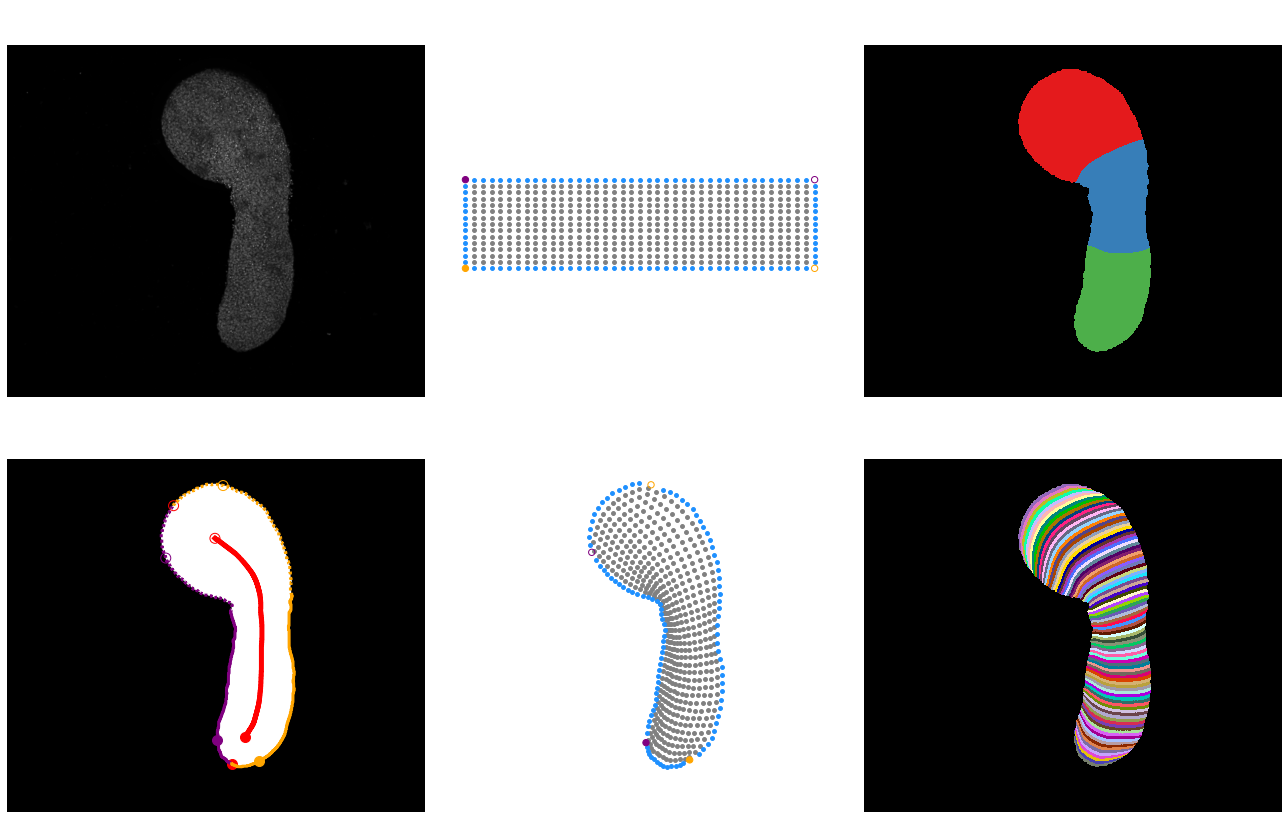

In [299]:
from matplotlib.colors import ListedColormap

fig,axs = plt.subplots(2,3,figsize=(18,12))

skel_path = find_longest_skeleton_path(skel)
corner_idxs, contour = find_template_corners(mask, skel_path, debug_plot=True, ax=axs[1,0])
grid = map_grid(corner_idxs, contour)

# lower grid density for schematic repr
grid = grid[::30,::30]

# grid_aspect = max(grid.shape) / min(grid.shape)
grid_aspect = 3
irg1, irg2 = np.meshgrid(
        np.arange(0, grid_aspect, grid_aspect/grid.shape[1]),
        np.arange(0, 1., 1/grid.shape[0]))

reg_grid = np.stack([irg1, irg2], axis=-1)

corner_mask = np.zeros(grid.shape[:-1], dtype=bool)
corner_mask[0,0] = True
corner_mask[-1,0] = True
corner_mask[0,-1] = True
corner_mask[-1,-1] = True
contour_mask = np.ones(grid.shape[:-1], dtype=bool)
contour_mask[1:-1,1:-1] = False

middle_mask = ~contour_mask

contour_mask[corner_mask] = False






corner_cmap = ['orange', 'orange', 'purple', 'purple']
corner_faces = ['orange', 'none', 'purple', 'none']
l3_cmap = ListedColormap(('black',) + plt.get_cmap('Set1').colors[:3], N=4)


axs[0,0].imshow(img1[0], cmap='Greys_r')
# axs[1,0].... $ debug plot

axs[0,1].scatter(reg_grid[middle_mask][...,0], reg_grid[middle_mask][...,1], color='grey', s=15)
axs[0,1].scatter(reg_grid[contour_mask][...,0], reg_grid[contour_mask][...,1], color='dodgerblue', s=15)
axs[0,1].scatter(reg_grid[corner_mask][...,0], reg_grid[corner_mask][...,1], color=corner_cmap, s=40, facecolors=corner_faces)
axs[0,1].set_ylim([-1.75, 2.75])
axs[0,1].set_xlim([-0.25, 3.25])

axs[1,1].imshow(mask, alpha=0)
axs[1,1].scatter(grid[middle_mask][...,1], grid[middle_mask][...,0], color='grey', s=15)
axs[1,1].scatter(grid[contour_mask][...,1], grid[contour_mask][...,0], color='dodgerblue', s=15)
axs[1,1].scatter(grid[corner_mask][...,1], grid[corner_mask][...,0], color=corner_cmap, s=40, facecolors=corner_faces)

axs[0,2].imshow(l3, cmap=l3_cmap, interpolation='nearest')
axs[1,2].imshow(l100, cmap='blk_glasbey_hv', interpolation='nearest')

for a in axs.flat:
    a.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('grid_mapping.png', bbox_inches='tight', dpi=300)
fig.savefig('grid_mapping.svg', bbox_inches='tight', dpi=300)